# Logo Detection

In [1]:
%matplotlib inline
#%reload_ext autoreload   # comment to correct 'PIL.Image' has no attribute 'register_extensions' in Colab
#%autoreload 2            # comment to correct 'PIL.Image' has no attribute 'register_extensions' in Colab

In [2]:
from pathlib import Path
import shutil
import time
import copy
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
False


## Load Data

In [4]:
ROOT = ''
DATA_DIR = os.path.join(ROOT, 'FlickrLogos-v2')
train_mean = np.array([0.44943, 0.4331 , 0.40244])
train_std = np.array([0.29053, 0.28417, 0.30194])

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'valid': transforms.Compose([
        #transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
}


In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

In [7]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}

In [8]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

In [9]:
class_names = image_datasets['train'].classes

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visulize a few Images

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = train_std * inp + train_mean
    inp = np.clip(inp, 0, 1)
    #plt.grid(None)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))  # if ‘PIL.Image’ has no attribute ‘register_extensions, comment out %reload, %autoreload

In [13]:
type(inputs), type(classes)

(torch.Tensor, torch.Tensor)

In [14]:
inputs.size(), classes.size()

(torch.Size([4, 3, 224, 224]), torch.Size([4]))

In [15]:
# Make a grid from batch
out = utils.make_grid(inputs)

In [16]:
plt.ion()

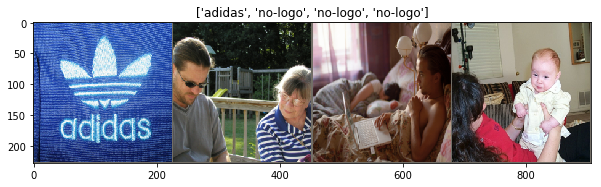

In [17]:
plt.figure(figsize=(10, 3))

imshow(out, title=[class_names[x] for x in classes])

## Training the model

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the Model Predictions

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
def save_model(model, path):
    os.makedirs(os.path.join(DATA_DIR, 'models'), exist_ok=True)
    torch.save(model.state_dict(), os.path.join(DATA_DIR, 'models', path))

In [21]:
def load_model(model, path):
    # model = TheModelClass(*args, **kwargs)
    # map_location https://pytorch.org/docs/master/torch.html#torch.loada
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'models', path), map_location=device.type))

## Convolutional Neural Network (CNN)

## Define a CNN1

In [38]:
import torch.nn as nn
import torch.nn.functional as F


class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 11, 4)
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(96, 192, 5)
        self.fc1 = nn.Linear(192 * 10 * 10, 4096)
        self.fc2 = nn.Linear(4096, 33)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 192 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [39]:
model_cnn1 = CNN1()
model_cnn1 = model_cnn1.to(device)

## Define a Loss function and optimizer

In [40]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cnn1.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [41]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [42]:
model_cnn1 = train_model(model_cnn1, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4467 Acc: 0.8209
valid Loss: 2.9027 Acc: 0.6098

Epoch 1/24
----------


Process Process-20:
Process Process-19:
Process Process-18:
Process Process-17:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lek/anaconda3/envs/pytorch_0_4/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lek/anaconda3/envs/pytorch_0_4/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lek/anaconda3/envs/pytorch_0_4/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lek/anaconda3/envs/pytorch_0_4/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lek/anaconda3/envs/pytorch_0_4/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lek/anaconda3/envs/pytorch_0_4/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, 

KeyboardInterrupt: 

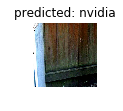

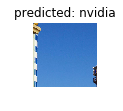

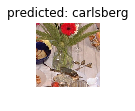

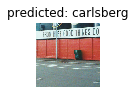

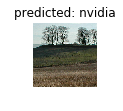

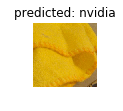

In [104]:
visualize_model(model_cnn1)

In [ ]:
save_model(model_ft, 'model_cnn1.pkl')

In [ ]:
load_model(model_ft, 'model_cnn1.pkl')

## Define a CNN

In [100]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 33)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [101]:
model_cnn = Net()
model_cnn = model_cnn.to(device)

## Define a Loss function and optimizer

In [102]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cnn.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [103]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [49]:
model_cnn = train_model(model_cnn, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 3.4484 Acc: 0.0055
valid Loss: 3.4616 Acc: 0.0122

Epoch 1/24
----------
train Loss: 3.4485 Acc: 0.0055
valid Loss: 3.4616 Acc: 0.0122

Epoch 2/24
----------
train Loss: 3.4487 Acc: 0.0055
valid Loss: 3.4616 Acc: 0.0122

Epoch 3/24
----------
train Loss: 3.4487 Acc: 0.0055
valid Loss: 3.4616 Acc: 0.0122

Epoch 4/24
----------
train Loss: 3.4483 Acc: 0.0055
valid Loss: 3.4616 Acc: 0.0122

Epoch 5/24
----------


Process Process-59:
Process Process-57:
Process Process-58:
Traceback (most recent call last):
Process Process-60:
Traceback (most recent call last):
  File "/home/lek/anaconda3/envs/pytorch_0_4/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lek/anaconda3/envs/pytorch_0_4/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/lek/anaconda3/envs/pytorch_0_4/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/lek/anaconda3/envs/pytorch_0_4/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/lek/anaconda3/envs/pytorch_0_4/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/lek/anaconda3/envs/pytorch_0_4/lib/python3.6/multiprocessing/proc

KeyboardInterrupt: 

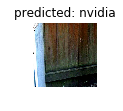

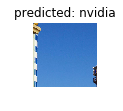

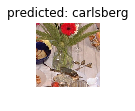

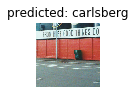

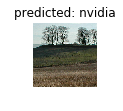

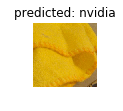

In [104]:
visualize_model(model_cnn)

## Finetuning the Convnet

In [91]:
model_ft = models.resnet18(pretrained=True)

In [92]:
num_ftrs = model_ft.fc.in_features

In [93]:
num_ftrs

512

In [94]:
model_ft.fc = nn.Linear(num_ftrs, 33)

In [95]:
model_ft = model_ft.to(device)

In [96]:
criterion = nn.CrossEntropyLoss()

In [97]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [98]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [58]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8586 Acc: 0.8225
valid Loss: 1.7123 Acc: 0.6337

Epoch 1/24
----------
train Loss: 0.6819 Acc: 0.8418
valid Loss: 1.8313 Acc: 0.6492

Epoch 2/24
----------
train Loss: 0.5565 Acc: 0.8780
valid Loss: 1.4768 Acc: 0.6902

Epoch 3/24
----------
train Loss: 0.4261 Acc: 0.8989
valid Loss: 1.3917 Acc: 0.7102

Epoch 4/24
----------
train Loss: 0.3398 Acc: 0.9192
valid Loss: 1.4304 Acc: 0.7102

Epoch 5/24
----------
train Loss: 0.2842 Acc: 0.9385
valid Loss: 1.3238 Acc: 0.7484

Epoch 6/24
----------
train Loss: 0.2020 Acc: 0.9593
valid Loss: 1.3707 Acc: 0.7350

Epoch 7/24
----------
train Loss: 0.1772 Acc: 0.9659
valid Loss: 1.2810 Acc: 0.7484

Epoch 8/24
----------
train Loss: 0.1603 Acc: 0.9681
valid Loss: 1.3314 Acc: 0.7557

Epoch 9/24
----------
train Loss: 0.1510 Acc: 0.9731
valid Loss: 1.3795 Acc: 0.7549

Epoch 10/24
----------
train Loss: 0.1352 Acc: 0.9769
valid Loss: 1.2465 Acc: 0.7598

Epoch 11/24
----------
train Loss: 0.1519 Acc: 0.9731
valid Loss

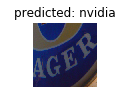

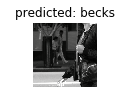

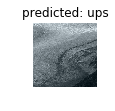

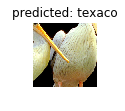

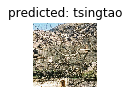

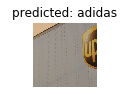

In [99]:
visualize_model(model_ft)

In [35]:
save_model(model_ft, 'model_ft.pkl')

In [75]:
device

device(type='cpu')

In [88]:
load_model(model_ft, 'model_ft.pkl')

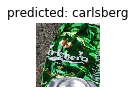

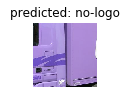

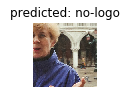

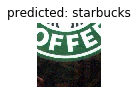

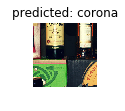

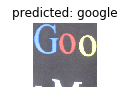

In [90]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

In [45]:
# Parameters of newly constructed modules have requires_grad=True by default
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [46]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 33)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate

In [47]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8946 Acc: 0.8203
valid Loss: 1.6232 Acc: 0.6341

Epoch 1/24
----------
train Loss: 0.7465 Acc: 0.8379
valid Loss: 1.4791 Acc: 0.6589

Epoch 2/24
----------
train Loss: 0.6438 Acc: 0.8505
valid Loss: 1.4353 Acc: 0.6598

Epoch 3/24
----------
train Loss: 0.5485 Acc: 0.8632
valid Loss: 1.3600 Acc: 0.6911

Epoch 4/24
----------
train Loss: 0.5306 Acc: 0.8753
valid Loss: 1.4005 Acc: 0.7061

Epoch 5/24
----------
train Loss: 0.4800 Acc: 0.8846
valid Loss: 1.3670 Acc: 0.7000

Epoch 6/24
----------
train Loss: 0.4585 Acc: 0.8890
valid Loss: 1.3329 Acc: 0.7102

Epoch 7/24
----------
train Loss: 0.4336 Acc: 0.9027
valid Loss: 1.2482 Acc: 0.7175

Epoch 8/24
----------
train Loss: 0.3732 Acc: 0.9198
valid Loss: 1.3101 Acc: 0.7256

Epoch 9/24
----------
train Loss: 0.3836 Acc: 0.9214
valid Loss: 1.3116 Acc: 0.7280

Epoch 10/24
----------
train Loss: 0.3895 Acc: 0.9121
valid Loss: 1.2464 Acc: 0.7293

Epoch 11/24
----------
train Loss: 0.3892 Acc: 0.9231
valid Loss

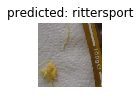

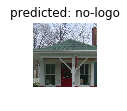

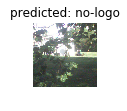

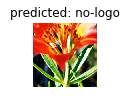

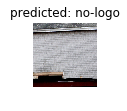

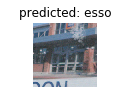

In [48]:
visualize_model(model_conv)

In [49]:
save_model(model_conv, 'model_conv.pkl')

In [64]:
load_model(model_conv, 'model_conv.pkl')

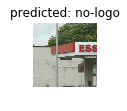

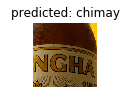

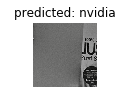

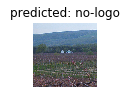

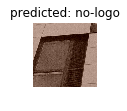

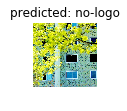

In [65]:
visualize_model(model_conv)